In [ ]:
! pip install autograd

In [1]:
import os
os.environ["GEOMSTATS_BACKEND"] = "autograd"

In [2]:
import geomstats
import math
import geomstats.backend as gs
from geomstats.geometry.spd_matrices import *
from geomstats.geometry.lie_group import *
from geomstats.datasets.utils import load_connectomes
from geomstats.visualization.spd_matrices import Ellipses
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npla
from geomstats.learning.denoising_geodesic import DenoisingGeodesic
from geomstats.geometry.general_linear import GeneralLinear
from geomstats.geometry.symmetric_matrices import SymmetricMatrices
from shape_project import *

INFO: Using autograd backend


# Learning distributions of healthy & schizophrenic brain shapes via denoising diffusion on manifolds.
## Authors: Marianne Arriola & Ryan Stofer

### Introduction and Background:

*INSERT BACKGROUND INFO HERE*

### Model Architecture:

*INSERT MODEL ARCHITECTURE INFO HERE*

### Data:

*INSERT DATA INFO HERE*

In [3]:
data, ids, target = load_connectomes()
print(data.shape)
print(ids)
print(target)

spd = SPDMatrices(28)
spd_affine = SPDAffineMetric(28)

(86, 28, 28)
[120873 135376 139149 146791 153870 167403 179564 179614 180172 191161
 197297 199397 216806 222333 224755 244353 259678 267327 273218 273762
 275939 277945 290112 293046 295807 298608 323839 337260 348851 403692
 404156 427131 427246 438939 441598 459624 467185 468228 468930 469535
 472665 474861 479741 495307 508321 522766 529803 537342 542571 558698
 559296 570576 573811 581828 582211 597203 609291 617191 641748 702920
 712549 737494 752943 767901 774591 775909 794470 797181 806111 818142
 823981 829335 835522 862050 867297 879556 906283 907482 909442 932646
 933065 934330 950671 963924 993348 993946]
[1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1
 0 0 0 1 1 1 0 0 0 1 0 1]


In [4]:
bool_list = list(map(bool,target))
flip_bool_list = [not elem for elem in bool_list]
schiz = data[bool_list]
print(schiz.shape)
schiz_spd = spd.projection(schiz)
healthy = data[flip_bool_list]
print(healthy.shape)
healthy_spd = spd.projection(healthy)

(40, 28, 28)
(46, 28, 28)


### Noise Scheduler

In [5]:
## Initialize manifold

# noise matrices lie on symmetric matrix manifold
noise_manifold = SymmetricMatrices(28)
noise_metric = noise_manifold.metric

# generated samples lie on spd manifold
learning_manifold = spd
learning_metric = SPDEuclideanMetric(28)

In [6]:
def forward_diffusion_sample(x_0, t, noisy_tangent_vec, noise_level=0.4, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    to_reach = x_0*sqrt_alphas_cumprod[t]
    noisy_tangent = noise_metric.log(to_reach,x_0)
    noisy_x = noise_metric.geodesic(initial_tangent_vec=noisy_tangent, initial_point=x_0)

    # sample noisy sample along geodesic
    noisy_x = noisy_x(1.0)
    noisy_sample = noise_metric.exp((sqrt_one_minus_alphas_cumprod[t] * noisy_tangent_vec),noisy_x)

    return noisy_sample, noisy_tangent_vec

def collect_samples(input_mat,T,step_size):
    
    symm_noise = np.random.standard_normal(input_mat.shape)
    symm_noise = np.tril(symm_noise) + np.tril(symm_noise, -1).T

    symm_noise = gs.eye(input_mat.shape[0])

    noisy_tangent = noise_manifold.random_tangent_vec(symm_noise)
    noisy_geodesic = noise_metric.geodesic(initial_tangent_vec=noisy_tangent, initial_point=symm_noise)

    for t in range(0,T,step_size):
        if t == 0:
            noisy_mats,noise_mats = forward_diffusion_sample(input_mat, t, noisy_geodesic(t))
        else:
            noisy_mat, noise_mat = forward_diffusion_sample(noisy_mats[0], t, noisy_geodesic(t))
            noisy_mats = gs.concatenate((noisy_mats,noisy_mat),axis=0)
            noise_mats = gs.concatenate((noise_mats,noise_mat),axis=0)
    return noisy_mats, noise_mats

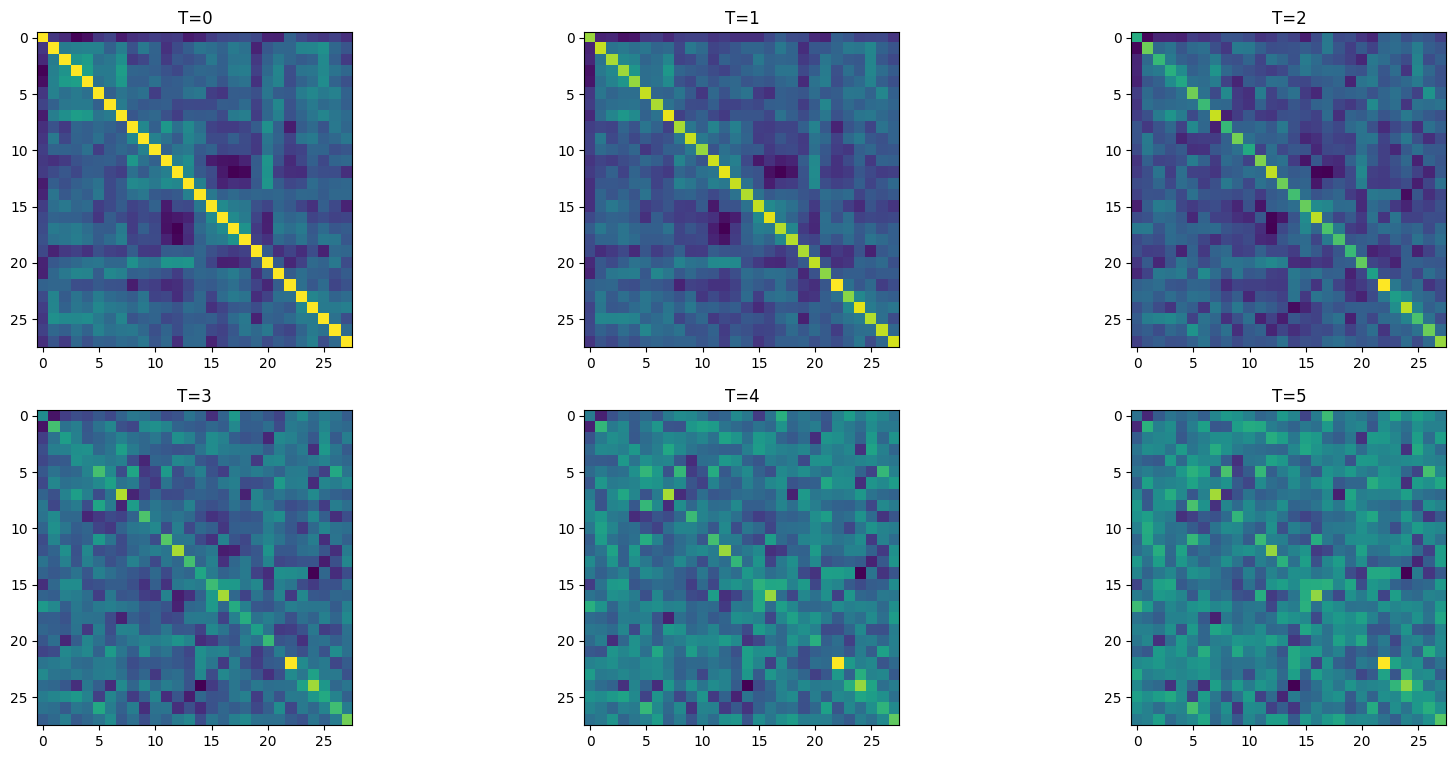

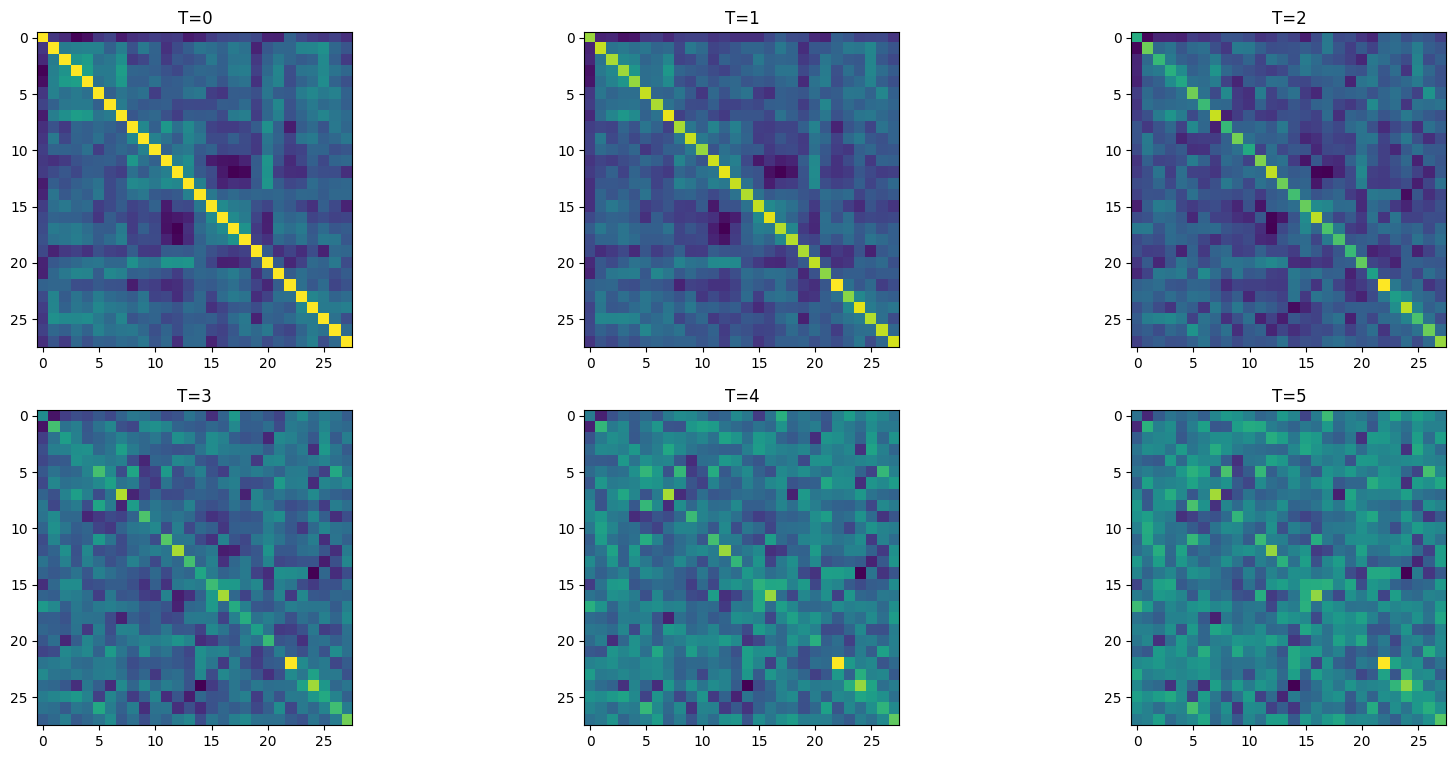

In [7]:
## Example forward diffusion process
# Define beta schedule
T = 6
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = gs.cumprod(alphas, axis=0)
alphas_cumprod_prev = gs.pad(alphas_cumprod[:-1], (1, 0))
alphas_cumprod_prev[0] = 1
sqrt_recip_alphas = gs.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = gs.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = gs.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

step = 1
noisy_mats,noise_mats = collect_samples(healthy_spd[20],T,step)
plot_mats(noisy_mats,2,3)

<Figure size 1500x2000 with 0 Axes>

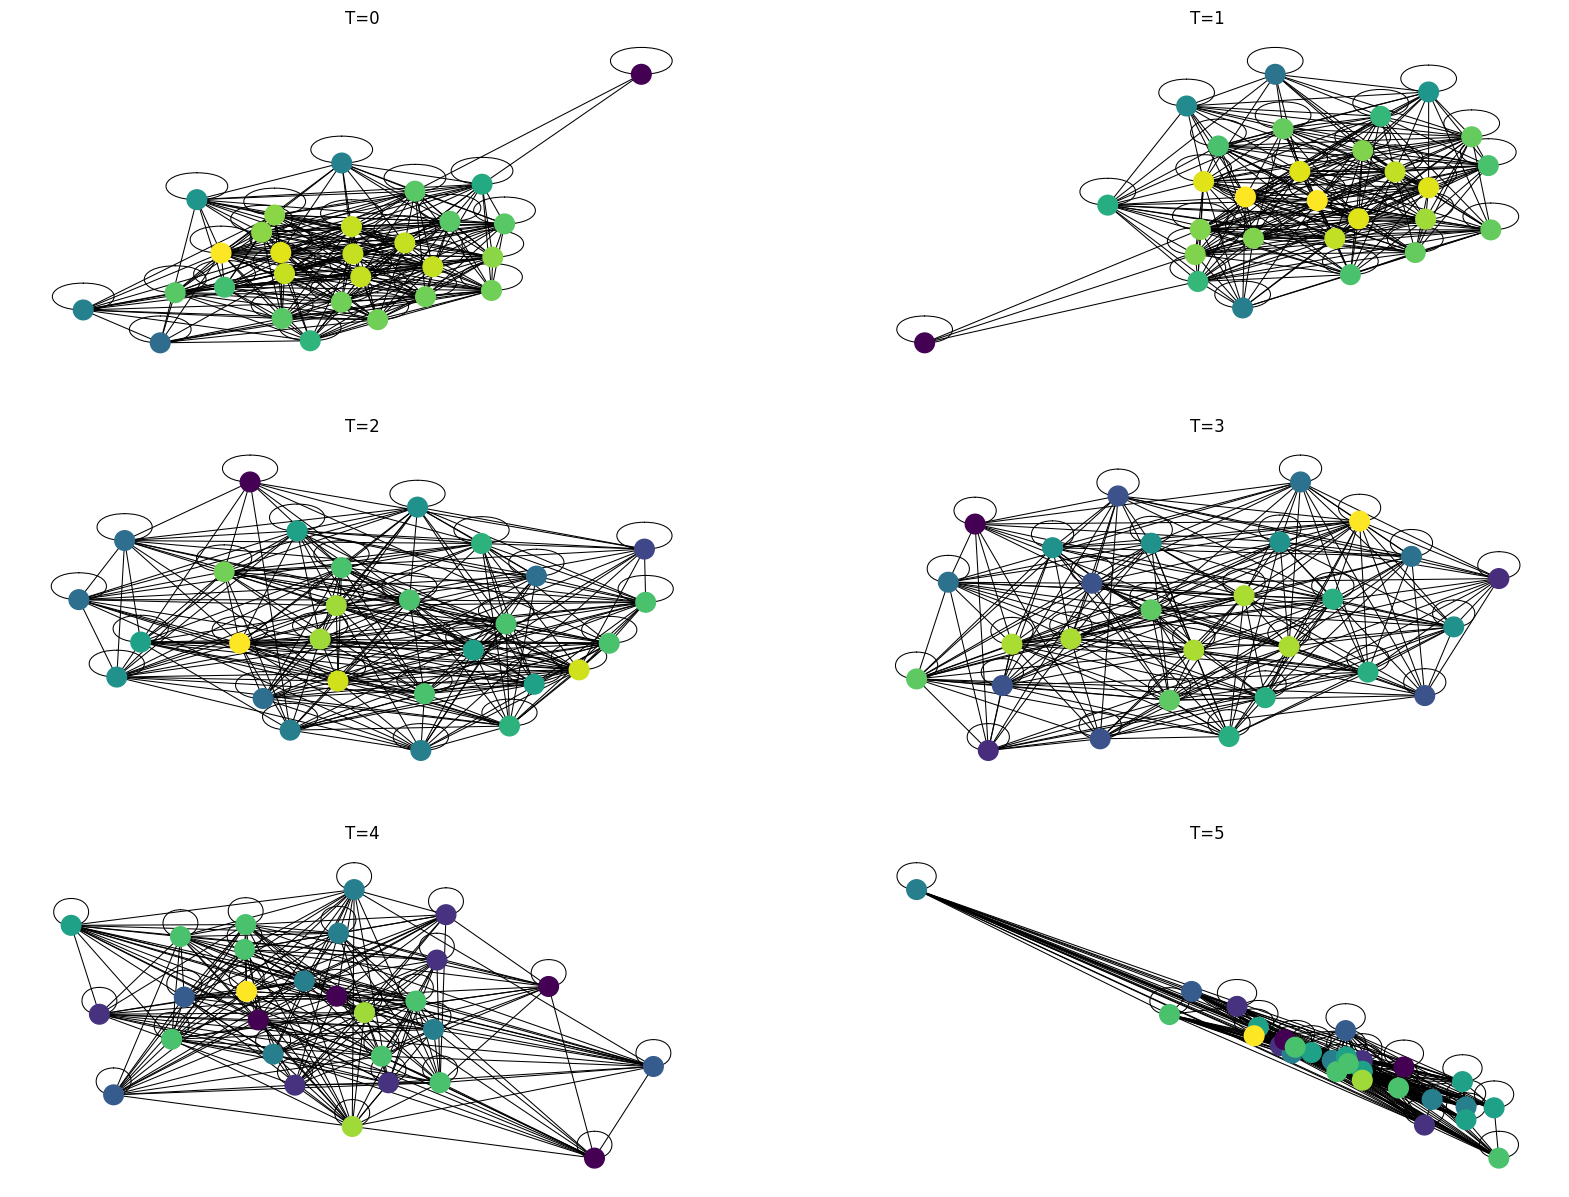

In [12]:
## Plot noisy graphs
plt.figure(figsize=(15,20))
nrow,ncol=3,2
figs,axs=plt.subplots(nrow, ncol, figsize=(20,15))
for im_id,noisy_mat in enumerate(noisy_mats):
    nx_graph = nx.from_numpy_array(np.ceil(noisy_mat))
    degrees = [n for n in nx.degree_centrality(nx_graph).values()]
    nx.draw(nx_graph,pos=None,with_labels=False,node_color=degrees,ax=axs[int((im_id)/ncol)][(im_id)%ncol],node_size=200,width=.75)
    axs[int((im_id)/ncol)][(im_id)%ncol].title.set_text(f'T={im_id}')
    #if im_id == 5: break

In [13]:
## Collect training/testing samples

h_trains, h_tests, h_cleans = [], [], []
for ind,sample in enumerate(healthy_spd[:10]):
    noisy_samples, noise_mats = collect_samples(sample,T,step)
    # train/test split
    h_trains.append(noisy_samples)
    h_cleans.append(noise_mats)

s_trains, s_tests, s_cleans = [], [], []
for ind,sample in enumerate(schiz_spd[:10]):
    noisy_samples, noise_mats = collect_samples(sample,T,step)
    # train/test split
    s_trains.append(noisy_samples)
    s_cleans.append(noise_mats)

### Learning distributions over manifold of healthy data

In [14]:
## Training on healthy brain samples from SPD manifold

# model init
gr_h = DenoisingGeodesic(
    space=learning_manifold, metric=learning_metric, verbose = True,
    center_X=False, method="riemannian", initialization="warm_start",max_iter=100, tol=1e-5, init_step_size=1e-6)
gr_h.intercept_ = h_trains[0][-1]  # theta0
gr_h.coef_ = learning_metric.log(h_trains[0][-2], h_trains[0][-1]) # theta1

x_train = np.squeeze(np.linspace(0, T, T))
 
# model fitting. learn noise geodesics on spd manifold of healthy brains
for ind,h_train in enumerate(h_trains):
    gr_h.fit(x_train,h_train,h_cleans[ind])

INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 3.993874502932241e-08
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 8.048744282411057e-08
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 9.086382761307242e-08
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 8.776193292963653e-08
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 8.618612851283823e-08
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 6.722224466823258e-08
INFO: Tolerance 

### Learning distributions over manifold of schizophrenic data

In [15]:
## Training on schizophrenic brain samples from SPD manifold

# model init
gr_s = DenoisingGeodesic(
    space=learning_manifold, metric=learning_metric, verbose = True,
    center_X=False, method="riemannian", initialization="warm_start",max_iter=100, tol=1e-5, init_step_size=1e-6)
gr_s.intercept_ = s_trains[0][-1]  # theta0
gr_s.coef_ = learning_metric.log(s_trains[0][-2], s_trains[0][-1]) # theta1

s_train = np.squeeze(np.linspace(0, T, T))
 
# model fitting. learn noise geodesics on spd manifold of schizophrenic brains
for ind,s_train in enumerate(s_trains):
    gr_s.fit(x_train,s_train,s_cleans[ind])

INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 3.4304969675184225e-08
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 7.21244693064963e-08
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 6.965906451414778e-08
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 8.086525603458054e-08
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 7.770491575103377e-08
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 7.919498550165509e-08
INFO: Tolerance 

### Denoising (generation)

generated distance to true healthy: 55.86806651224097 noisy distance: 869.8804277225199
generated distance to true schizophrenic: 44.224333532930814 noisy distance: 742.7339899139956


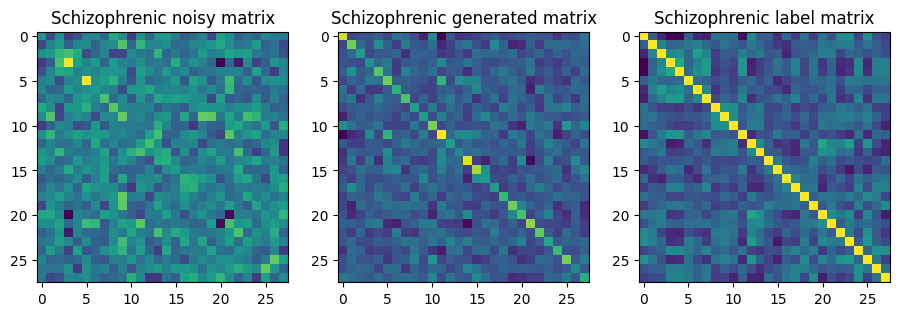

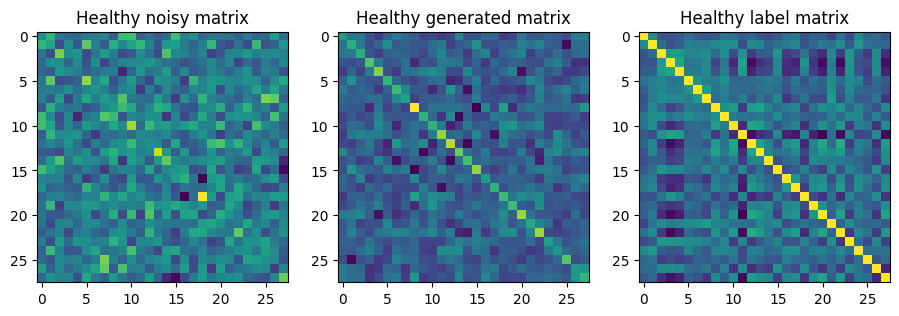

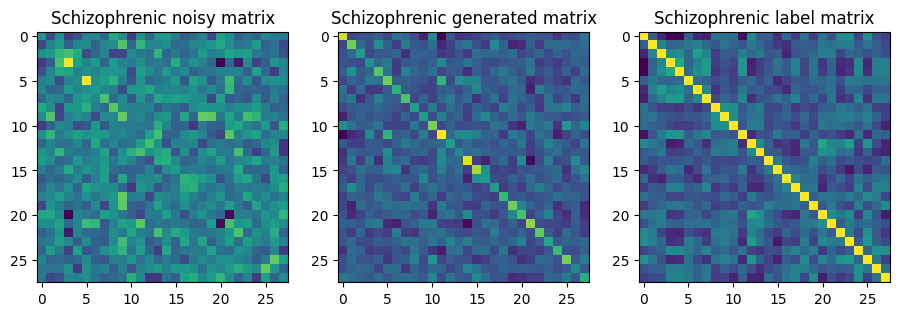

In [22]:
## Evaluation
h_label = healthy_spd[30]
s_label = schiz_spd[2]

def denoise(x,y_,T,gr):
    '''use model predictions to produce denoised samples'''
    # given clean test example, retrieve noisy samples
    noisy_mats,noise_mats = collect_samples(y_,T,step)
    to_denoise = noisy_mats[-1]
    model_pred = None
    
    for t in range(T)[::-1]:
        # Call model (current image - noise prediction) to get predicted noise
        model_pred = gr._model(np.array([t]), gr.coef_, gr.intercept_)[0]
        model_pred = betas[t] * model_pred

        model_pred = model_pred / sqrt_one_minus_alphas_cumprod[t]

        # tangent from old noisy (spd) to denoised (spd)
        model_diff = learning_metric.log(model_pred, to_denoise)
        model_mean = learning_metric.geodesic(initial_tangent_vec=model_diff, initial_point=to_denoise)(1.0)

        if t==0:
            to_denoise = model_mean
        else:
            symm_noise = np.random.standard_normal(to_denoise.shape)
            symm_noise = np.tril(symm_noise) + np.tril(symm_noise, -1).T
            to_denoise = learning_metric.exp((gs.sqrt(posterior_variance[t]) * symm_noise), model_mean)[0]

    distances = learning_metric.squared_dist(to_denoise, y_)

    return to_denoise, noisy_mats[-1], distances

h_preds, noisy_h, distances = denoise(x_train,h_label, T, gr_h)
print('generated distance to true healthy:',distances[0], 'noisy distance:', learning_metric.squared_dist(noisy_h[-1], h_label))

plot_results(h_label,h_preds[-1],noisy_h,'Healthy')

s_preds, noisy_s, distances = denoise(x_train,s_label, T, gr_s)
print('generated distance to true schizophrenic:',distances[0], 'noisy distance:', learning_metric.squared_dist(noisy_s[-1], s_label))
plot_results(s_label,s_preds[-1],noisy_s,'Schizophrenic')

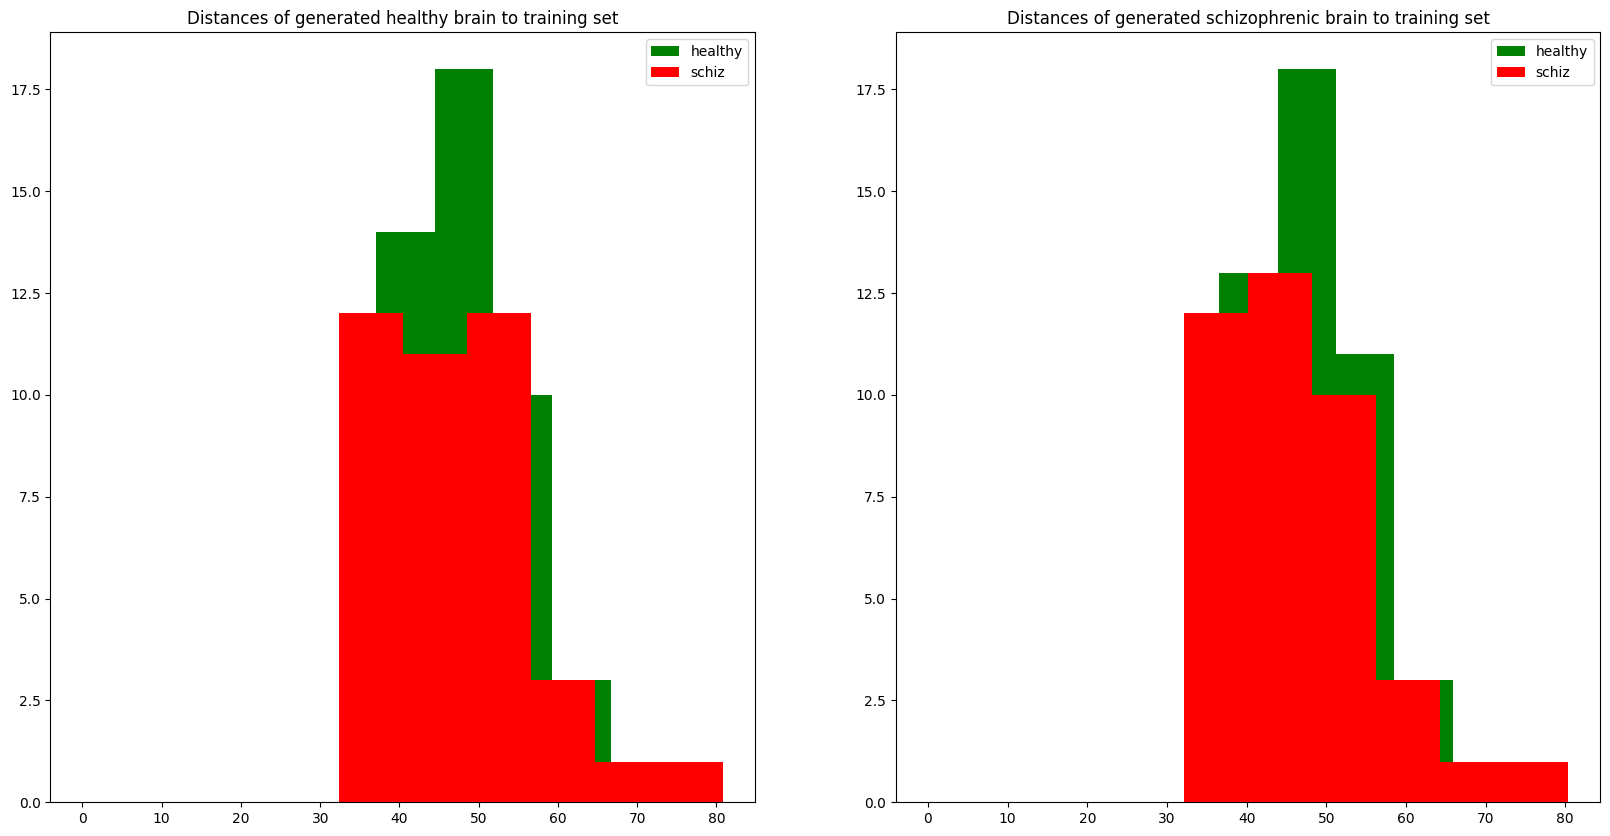

In [23]:
#f, ax_arr = plt.subplots(2,2,figsize=(20,10))
dist_metric = SPDEuclideanMetric(28)
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
sqrd_dist=compute_sqr_dist(h_preds, healthy_spd, dist_metric)
ax0.hist(sqrd_dist,range=(0,np.max(sqrd_dist)),color='green',stacked=True)
sqrd_dist=compute_sqr_dist(h_preds, schiz_spd, dist_metric)
ax0.hist(sqrd_dist,range=(0,np.max(sqrd_dist)),color='red',stacked=True)
ax0.legend(['healthy','schiz'])
ax0.title.set_text('Distances of generated healthy brain to training set')

sqrd_dist=compute_sqr_dist(s_preds, healthy_spd, dist_metric)
ax1.hist(sqrd_dist,range=(0,np.max(sqrd_dist)),color='green',stacked=True)
sqrd_dist=compute_sqr_dist(s_preds, schiz_spd, dist_metric)
ax1.hist(sqrd_dist,range=(0,np.max(sqrd_dist)),color='red',stacked=True)
ax1.legend(['healthy','schiz'])
ax1.title.set_text('Distances of generated schizophrenic brain to training set')

plt.show()


### Similarity of generated samples to training set

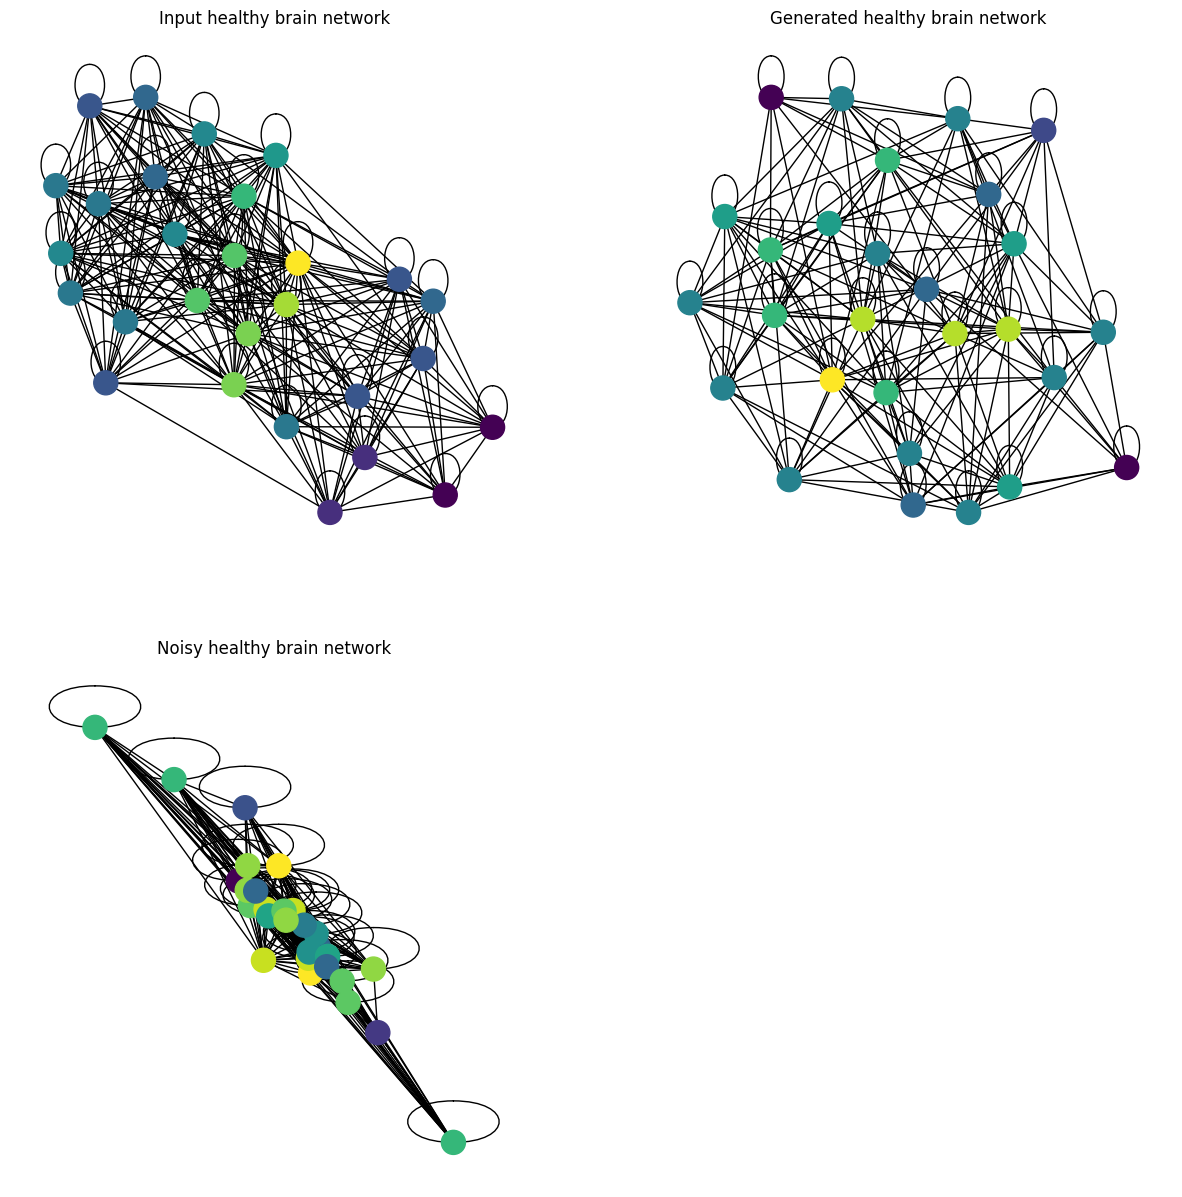

In [31]:
adj_label, adj_pred, adj_noisy = np.ceil(h_label),np.ceil(h_preds[0]),np.ceil(noisy_h)
g_label = nx.from_numpy_array(adj_label)
g_pred = nx.from_numpy_array(adj_pred)
g_noisy = nx.from_numpy_array(adj_noisy)
plt.figure(figsize=(15,15))
plot_graphs_spatial(g_label,221,"Input healthy brain network")
plot_graphs_spatial(g_pred,222,"Generated healthy brain network")
plot_graphs_spatial(g_noisy,223,"Noisy healthy brain network")

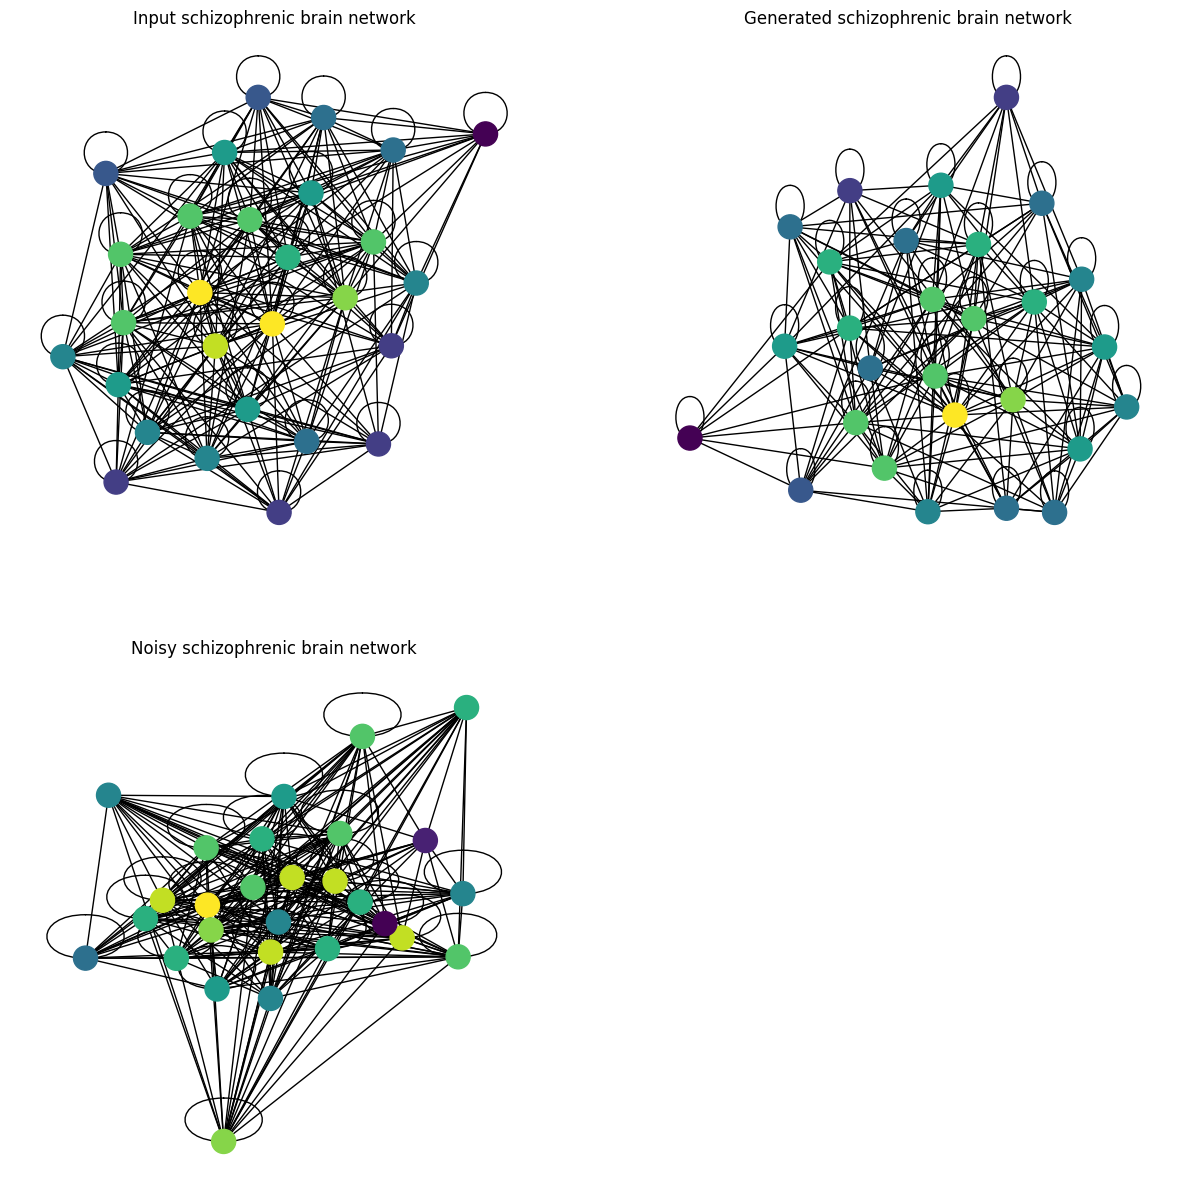

In [30]:
adj_label, adj_pred, adj_noisy = np.ceil(s_label),np.ceil(s_preds[0]),np.ceil(noisy_s)
g_label = nx.from_numpy_array(adj_label)
g_pred = nx.from_numpy_array(adj_pred)
g_noisy = nx.from_numpy_array(adj_noisy)
plt.figure(figsize=(15,15))
plot_graphs_spatial(g_label,221,"Input schizophrenic brain network")
plot_graphs_spatial(g_pred,222,"Generated schizophrenic brain network")
plot_graphs_spatial(g_noisy,223,"Noisy schizophrenic brain network")

Sources:
- Diffusion Model Tutorial: https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=uuckjpW_k1LN